# ROICaT Classification Colab Notebook

This Colab notebook allows you to easily classify ROIs in your calcium imaging data, using a stable version of [ROICaT](https://doi.org/10.1038/s41586-021-03819-2). 


This Colab notebook is designed to work with  **Suite2p output file** (stat.npy and ops.npy).


**Before we start**

We **STRONGLY** recommend running this Colab notebook with GPU. Please check your runtime setting:

_Runtime -> Change runtime type -> Hardware accelerator -> choose GPU_


**More information**

FAQ on how to play with ROICaT is [here](https://alphafold.ebi.ac.uk/faq).

If you have any questions not covered in the FAQ, please don't hesitate to open a new issue tap on [ROICaT github page]().

In [1]:
#@title Install ROICaT
#@markdown Please execute this cell by pressing the _Play_ button on the left. This process will take less than 5 min.

#@markdown Please note that this cell installs ROICaT on the Colab **TEMPORARY** directory in the cloud, not on your local machine or google drive.

#@markdown After running this cell, please click the **"RESTART RUNTIME"** button at the bottom of this cell.

# Clone ROICaT repository
GIT_REPO = 'https://github.com/RichieHakim/ROICaT.git'
!git clone {GIT_REPO}

# Install ROICaT
import os
os.chdir('/content/ROICaT')
!pip uninstall -y tensorflow # Uninstall default tensorflow to avoid any potential conflict
!pip install --user -v -e .[core]

Cloning into 'ROICaT'...
remote: Enumerating objects: 2803, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 2803 (delta 6), reused 22 (delta 4), pack-reused 2691
Receiving objects: 100% (2803/2803), 265.23 MiB | 24.45 MiB/s, done.
Resolving deltas: 100% (1761/1761), done.
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/ROICaT
  Running command python setup.py egg_info
  {'core': ['einops==0.6.1', 'hdbscan==0.8.29', 'jupyter==1.0.0', 'kymatio==0.3.0', 'matplotlib==3.7.1', 'natsort==8.3.1', 'numpy==1.24.3', 'opencv_contrib_python==4.7.0.72', 'optuna==3.1.1', 'paramiko==3.1.0', 'Pillow==9.5.0', 'pytest==7.3.1', 'scikit_learn==1.2.2', 'scipy==1

In [1]:
#@title Install Plotting Libraries
!pip install jupyter-dash plotly pandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 30.5 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.0
    Uninstalling Werkzeug-2.3.0:
      Successfully uninstalled Werkzeug-2.3.0
  Attempting uninstall: flask
    Found existing installation: Flask 2.2.4
    Uninstalling Flask-2.2.4:
      Successfully uninstalled Flask-2.2.4


In [2]:
#@title Load modules

# Load basic modules
import os
import zipfile
from pathlib import Path
import copy
from functools import partial
from datetime import datetime
from tqdm import tqdm

import random
import numpy as np
import sklearn
from umap import UMAP

import torch
import torchvision

# Load plotting modules
import io
import base64
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

/root/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/root/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword 

In [3]:
#@title Helper Functions
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU instead")
    return device

def dataloader_params_wrapper(colab_device):
  dataloader_params = {}
  if colab_device == torch.device('cuda'):
    print("Using GPU")
    dataloader_params['batchSize_dataloader'] = 8
    dataloader_params['pinMemory_dataloader'] = True
    dataloader_params['numWorkers_dataloader'] = -1
    dataloader_params['persistentWorkers_dataloader'] = True
    dataloader_params['prefetchFactor_dataloader'] = 2
  elif colab_device == torch.device('cpu'):
    print("Using CPU")
    dataloader_params['batchSize_dataloader'] = 1
    dataloader_params['pinMemory_dataloader'] = False
    dataloader_params['numWorkers_dataloader'] = 0
    dataloader_params['persistentWorkers_dataloader'] = False
    dataloader_params['prefetchFactor_dataloader'] = None
  else:
    print("Unknown environment. Please double-check your runtime setting.")
  return dataloader_params

In [4]:
#@title Plotting Functions
 
def colab_UMAP_plotter(x, y, ims_subset, sizex=0.7, sizey=0.7, opacity=1):
  """
  UMAP plotter for Google Colab Environment:

  Args:
    x (list):
        1st UMAP factor embedding of ROIs pre-classified as neurons
    y (list):
        2nd UMAP factor embedding of ROIs pre-classified as neurons
    ims_subset (list of np.ndarray of images):
        ROI images
    sizex (float):
        Horizontal ROI image size on the UMAP plot
    sizey (float):
        Vertical ROI image size on the UMAP plot
    opacity (float):
        Opacity of the ROI image on the UMAP plot
  """
  # Create traces from data
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y, mode='markers'))

  # Here, we annotate each UMAP datapoint with corresponding ROI image so that you can choose a subset of GOOD ROIs.
  for x0, y0, img in zip(x, y, ims_subset):
    # Normalize img
    img_normalized = (img - np.min(img)) / np.max(img)
    # Create temporary ROI image, png format
    img_png = Image.fromarray(np.uint8(img_normalized * 255), 'L')
    temp_image = io.BytesIO()
    img_png.save(temp_image, format='png')
    temp_image.seek(0)

    # Convert the BytesIO object to a base64 string
    image_string = "data:image/png;base64," + base64.b64encode(temp_image.getvalue()).decode('utf-8')

    # Add ROI image on each corresponding UMAP datapoint
    fig.add_layout_image(dict(
        source=image_string,
        xref='x',
        yref='y',
        x=x0,
        y=y0,
        sizex=sizex,
        sizey=sizey,
        opacity=opacity,
        layer="above"
    ))

  return fig


## crappy heuristic for spreading out points
def get_spread_out_points(embeddings, thresh_dist=0.3, n_iter=3):

    def make_dist_mat(embeddings):
        dist_mat = sklearn.neighbors.NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=None).fit(embeddings).kneighbors_graph(embeddings, n_neighbors=300, mode='distance').toarray()
        dist_mat[dist_mat==0.0] = np.nan
        return dist_mat

    def prune(dist_mat_pruned, thresh_dist, bool_good):
        idx_rand = np.random.permutation(np.arange(dist_mat_pruned.shape[0]))

        for idx in tqdm(idx_rand):
            if np.nanmin(dist_mat_pruned[idx]) < thresh_dist:

                dist_mat_pruned[idx] = np.nan
                dist_mat_pruned[:,idx] = np.nan

                bool_good[idx] = False
        return dist_mat_pruned, bool_good

    def grow(dist_mat_pruned, dist_mat_raw, thresh_dist, bool_good):
        idx_good = np.nonzero(bool_good)[0]
        idx_bad = np.nonzero(~bool_good)[0]
        for idx in idx_bad:
            if np.nanmin(dist_mat_raw[idx][idx_good]) > thresh_dist:
                dist_mat_pruned[idx] = dist_mat_raw[idx]
                dist_mat_pruned[:,idx] = dist_mat_raw[:,idx]
                bool_good[idx] = True
        return dist_mat_pruned, bool_good

    dist_mat_raw = make_dist_mat(embeddings)

    n_sf = embeddings.shape[0]

    bool_good = np.ones(n_sf, dtype=np.bool_)
    
    dist_mat_pruned = copy.deepcopy(dist_mat_raw)
    
    for ii in range(n_iter):
        dist_mat_pruned, bool_good = prune(dist_mat_pruned, thresh_dist, bool_good)
        dist_mat_pruned, bool_good = grow(dist_mat_pruned, dist_mat_raw, thresh_dist, bool_good)
    dist_mat_pruned, bool_good = prune(dist_mat_pruned, thresh_dist, bool_good)

    return bool_good, dist_mat_pruned

In [5]:
#@title Load ROICaT

import sys
sys.path.append('/content/ROICaT')

import roicat

colab_device = set_device()

GPU is available


# Import data

## Prepare files

### Mount google drive (OPTION 1: RECOMMENDED)

In [8]:
#@markdown You can upload your data onto gdrive and mount the drive to access.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
#@markdown ### Enter your suite2p files directory:
dir_s2p = '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230505/' #@param {type:"string"}

In [10]:
#@markdown Find stat / ops files
paths_statFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch='stat.npy', depth=8)
paths_opsFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch='ops.npy', depth=8)
print('paths_statFiles')
display(paths_statFiles)
print('paths_opsFiles')
display(paths_opsFiles)

paths_statFiles


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230505/stat.npy']

paths_opsFiles


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230505/ops.npy']

### Upload file from local (OPTION 2)


In [7]:
#@markdown This cell allows you to load files from local. Please note that loading file from local to Colab cloud is pretty slow. Also, you should **LOAD FILE AGAIN** if runtime terminates.

#@markdown If you have **nested** suite2p output file structures from multiple sessions, create and upload a **zip file**. This cell detects and extracts uploaded zip file.


from google.colab import files
uploaded = files.upload()

for file_name in list(uploaded.keys()):
  file_path = Path.cwd() / file_name
  if file_path.exists():
    if zipfile.is_zipfile(file_path):
      print("Zip file detected: ", file_path)
      with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(Path.cwd())
        print("Zip file extracted to: ", Path.cwd())
    else:
      print("Uploaded file is not zip file: ", file_path)
  else:
    print("Failed to detect uploaded file path: ", file_path)

dir_s2p = os.getcwd()

paths_statFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch='stat.npy', depth=8)
paths_opsFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch='ops.npy', depth=8)
print('paths_statFiles')
display(paths_statFiles)
print('paths_opsFiles')
display(paths_opsFiles)

Saving test_zip.zip to test_zip.zip
Zip file detected:  /content/test_zip.zip
Zip file extracted to:  /content
paths_statFiles


[]

paths_opsFiles


[]

### Load ROIs

In [11]:
#@markdown ### Enter micrometers per pixel of the imaging FOV:
um_per_pixel = 2.5 #@param {type:"number"}
visualize_ROI_size = [int(90/um_per_pixel), int(90/um_per_pixel)]

In [15]:
#@markdown Load ROIs...

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_statFiles,
    paths_opsFiles=paths_opsFiles,
    um_per_pixel=um_per_pixel,
    new_or_old_suite2p='new',
    out_height_width=visualize_ROI_size,
    type_meanImg='meanImgE',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


### Pass ROI images through ROInet

In [17]:
#@markdown With CPU only, this process is pretty slow...

roinet = roicat.ROInet.ROInet_embedder(
    device=colab_device,
    dir_networkFiles=os.getcwd(),
    download_method='check_local_first',
    download_url='https://osf.io/c8m3b/download',
#     download_hash='3d767bfec446c91dad8e5909c1b697c1',
    forward_pass_version='head',
    verbose=True,
)

dataloader_params = dataloader_params_wrapper(colab_device)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    **dataloader_params,
);

roinet.generate_latents();

File already exists locally: /content/ROInet.zip
Hash of local file does not match provided hash_hex.
Hash of local file: 357a8d9b630ec79f3e015d0056a4c2d5
Hash provided in hash_hex: None


100%|██████████| 100M/100M [00:03<00:00, 28.7MB/s] 


Hash of downloaded file does not match hash_hex.
Hash of downloaded file: 357a8d9b630ec79f3e015d0056a4c2d5
Hash provided in hash_hex: None
Extracting /content/ROInet.zip to /content.
Completed zip extraction.
['/content/ROInet_classification_20220902', '/content/ROInet_classification_20220902/model.py', '/content/ROInet_classification_20220902/classifier.pkl', '/content/ROInet_classification_20220902/params.json', '/content/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth', '/content/ROInet_classification_20220902/__pycache__', '/content/ROInet_classification_20220902/__pycache__/model.cpython-39.pyc']
Imported model from /content/ROInet_classification_20220902/model.py
Loaded params_model from /content/ROInet_classification_20220902/params.json


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.



Generated network using params_model
Loaded state_dict into network from /content/ROInet_classification_20220902/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda
Using GPU
Starting: resizing ROIs


/content/ROICaT/roicat/ROInet.py:330: UserWarning:







Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


  0%|          | 0/318 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning:

operator() profile_node %283 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501: UserWarning:

operator() profile_node %283 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)

100%|██████████| 318/318 [00:11<00:00, 28.76it/s]

completed: running data through network



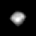

In [18]:
#@markdown Visualize ROI images
%matplotlib notebook
roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

# draw selection

In [19]:
#@markdown Prepare UMAP

n_pcs_toKeep_nn = 40
n_pcs_toKeep_swt = 10

comp_nn, scores_nn, SVs, EVR_nn = roicat.helpers.torch_pca(roinet.latents, device=colab_device, rank=n_pcs_toKeep_nn, zscore=False)
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)

umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
emb_umap = umap.fit_transform(features_norm)
# emb_nn = umap.fit_transform(scores_nn)

bool_good, dist_mat_pruned = get_spread_out_points(emb_umap, thresh_dist=0.25, n_iter=3)
idx_good = np.nonzero(bool_good)[0]

  0%|          | 0/2538 [00:00<?, ?it/s]<ipython-input-4-879a4d9bed32>:66: RuntimeWarning:

All-NaN slice encountered

100%|██████████| 2538/2538 [00:00<00:00, 56923.77it/s]



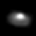
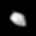
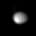
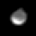
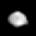
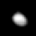
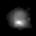
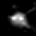
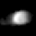
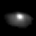
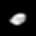
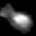
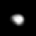
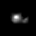
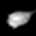
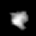
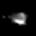
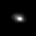
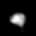
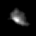
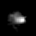
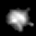
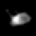
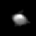
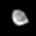
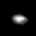
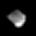
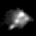
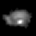
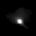
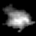
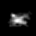
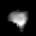
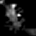
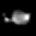
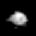
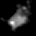
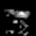
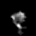
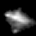
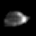
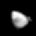
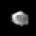
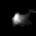
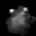
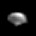
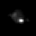
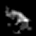
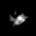
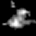
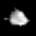
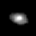
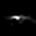
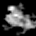
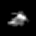
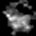
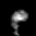
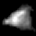
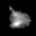
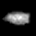
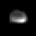
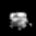
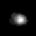
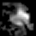
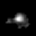
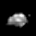
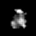
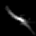
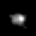
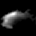
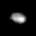
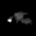
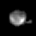
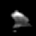
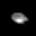
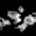
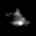
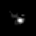
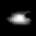
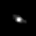
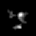
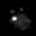
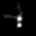
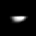
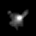
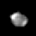
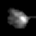
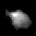
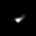
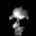
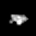
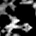
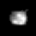
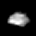
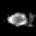
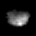
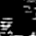
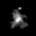
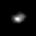
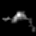
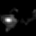
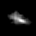
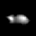
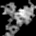
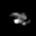
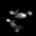
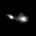
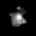
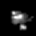
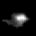
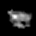
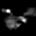
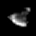
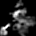
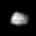
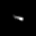
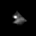
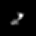
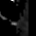
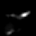
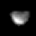
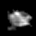
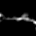
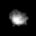
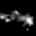
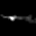
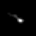
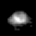
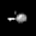
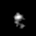
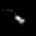
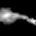
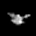
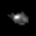
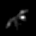
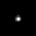
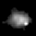
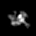
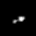
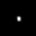
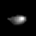
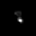
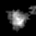
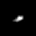
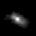
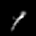
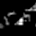
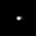
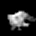
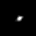
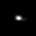
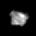
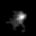
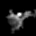
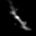
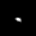
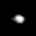
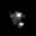
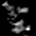
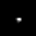
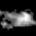
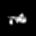
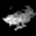
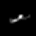
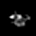
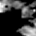
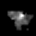
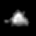
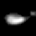
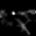
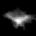
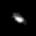
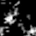
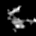
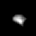
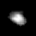
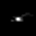
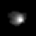
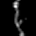
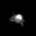
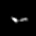
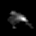
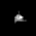
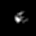
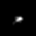
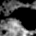
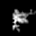
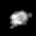
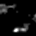
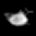
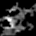
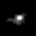
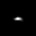
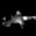
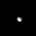
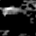
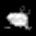
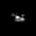
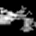
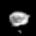
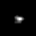
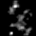
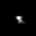
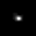
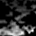
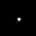
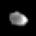
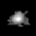
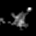
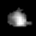
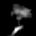
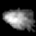
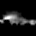
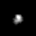
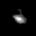
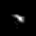
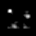
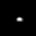
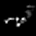
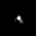
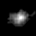
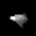
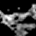
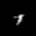
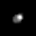
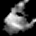
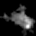
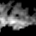
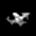
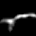
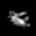
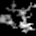
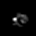
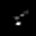
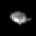
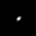
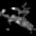
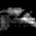
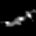
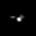
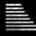
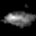
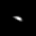
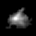
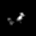
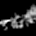
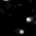
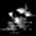
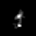
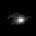
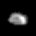
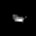
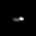
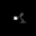
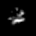
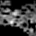
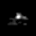
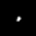
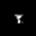
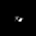
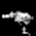
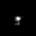
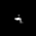
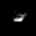
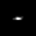
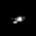
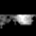
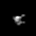
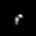
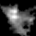
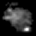
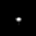
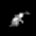
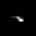
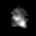
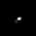
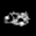
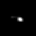
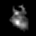
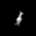
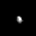
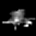
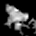
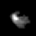
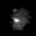
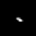
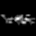
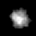
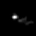
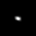
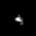
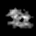
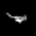
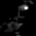
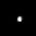
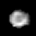
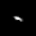
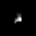
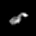
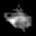
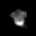
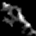
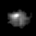
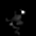
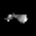
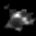
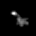
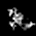
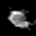
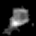
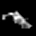
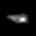
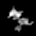
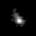
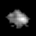
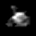

In [20]:
#@markdown Visualize ROIs
# UMAP drawing plus ROI image
x, y, ims_subset = emb_umap[idx_good,0], emb_umap[idx_good,1], roinet.ROI_images_rs[idx_good]

fig = colab_UMAP_plotter(x,
                   y,
                   ims_subset,
                   sizex = 0.7,
                   sizey = 0.7,
                   opacity = 1)

fig.show(width=1000, height=1000)

In [21]:
#@markdown Load interactive plot so that you can draw selection and choose good ROIs.

#@markdown Please note that loading interactive plot in Colab environment is **very slow**!!!

#@markdown After drawing your selection, please click the button **Retrieve Indices of Selected Points**
# Build App
app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id='graph',
        figure=fig,
        config={
            'displayModeBar': True,
            'modeBarButtonsToAdd':['drawline',
                                  'drawopenpath',
                                  'drawclosedpath',
                                  'drawcircle',
                                  'drawrect',
                                  'eraseshape'
                                 ]
        }
    ),
    html.Button("Retrieve Indices of Selected Points", id='btn'),
    html.Div(id='selected-data')
])

@app.callback(
    Output('selected-data', 'children'),
    [Input('graph', 'selectedData'), Input('btn', 'n_clicks')]
)

def display_selected_data(selectedData, n_clicks):
    if selectedData and n_clicks:
        points = selectedData['points']
        # Update the global variable
        global selected_indices
        selected_indices = [point['pointIndex'] for point in points]

# Run app and retrieve the indices of the selected points
app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

Number of 'good' and 'bad' ROIs from each session:
['good: 132 / bad: 2406']



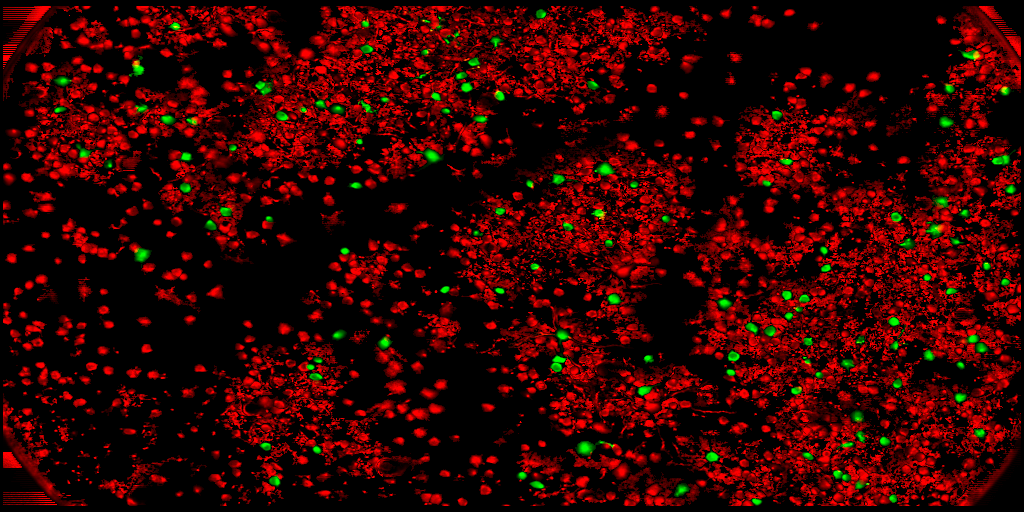

In [22]:
#@markdown Visualize Classification results
# Index good ROIs
n_sessions = len(data.ROI_images)
idx_session_cat = np.concatenate([[ii]*data.ROI_images[ii].shape[0] for ii in range(n_sessions)])
bool_good_cat = roicat.helpers.idx2bool(selected_indices, length=len(idx_session_cat))
preds_good_sessions = [np.int64((bool_good_cat * (idx_session_cat==ii))[idx_session_cat==ii]) for ii in range(data.n_sessions)]

print(f"Number of 'good' and 'bad' ROIs from each session:")
print([f"good: {p.sum()} / bad: {(p!=1).sum()}" for p in preds_good_sessions])

# Visualize
%matplotlib inline
FOVs_colored = roicat.visualization.compute_colored_FOV(
    spatialFootprints=data.spatialFootprints,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    labels=preds_good_sessions,
    cmap=roicat.helpers.simple_cmap([[1,0,0],[0,1,0]]),
)

roicat.visualization.display_toggle_image_stack(FOVs_colored)

# Save Results to Local

In [23]:
#@markdown This cell downloads output file to your local computer.
save_filename = datetime.now().strftime("%Y%m%d-%H%M%S") + '_ROICaT.classification_drawn.results' + '.pkl'
path_save = Path.cwd() / save_filename
print(f'Classification_results_on_Colab_cloud: {path_save}')

classification_output = {
    'preds': preds_good_sessions,
    'spatialFootprints': data.spatialFootprints,
    'FOV_height': data.FOV_height,
    'FOV_width': data.FOV_width,
}

roicat.helpers.pickle_save(classification_output, path_save)

from google.colab import files
files.download(path_save) 

Classification_results_on_Colab_cloud: /content/20230530-014053_ROICaT.classification_drawn.results.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>